In [ ]:
# !pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.0 MB/s eta 0:00:00


In [43]:
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

In [44]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [45]:
comments = load_dataset("imdb")

In [46]:
def tokenize_text(text):
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True)
    return tokens


# shuffle data
train_data = comments['train'].shuffle(seed=42).select([i for i in range(25000)])
tokenized_comments = [tokenize_text(comment['text']) for comment in train_data]
test_data = comments['test'].shuffle(seed=42).select([i for i in range(25000)])
tokenized_test_comments = [tokenize_text(comment['text']) for comment in test_data]

In [47]:
padded_data = pad_sequence([torch.tensor(tokenized_comment) for tokenized_comment in tokenized_comments], batch_first=True, padding_value=0)
input_ids = torch.tensor(padded_data)
labels = torch.tensor([comment['label'] for comment in train_data])

padded_valid_data = pad_sequence([torch.tensor(tokenized_comment) for tokenized_comment in tokenized_test_comments], batch_first=True, padding_value=0)
test_ids = torch.tensor(padded_valid_data)
test_labels = torch.tensor([comment['label'] for comment in test_data])

train_set_bert = TensorDataset(input_ids, labels)
test_set_bert = TensorDataset(test_ids, test_labels)

C:\Users\10405\AppData\Local\Temp\ipykernel_11648\2446553997.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(padded_data)
C:\Users\10405\AppData\Local\Temp\ipykernel_11648\2446553997.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ids = torch.tensor(padded_valid_data)


In [48]:
# split dataset to train set and validation set
def split_data(dataset, train_ratio = 0.8):

    # split ratio
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    return train_dataset, val_dataset


In [49]:
train_dataset_bert, val_dataset_bert = split_data(train_set_bert)

In [50]:
bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(torch.device("cuda"))
optimizer = AdamW(bert.parameters(), lr=1e-5)
loss_fn = torch.nn.BCELoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [51]:
# train bert
def train_bert(model, num_epochs, batch_size, train_dataset, val_dataset, optimizer, loss_fn):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    device = torch.device("cuda")

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        train_J = 0
        train_correct = 0
        train_total = 0
        for batch in train_loader:
            input_ids, labels = batch
            optimizer.zero_grad()
            model = model.to(device)
            outputs = model(input_ids.to(device), labels=labels.to(device))
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_J += loss.to(torch.device('cpu')).item()

            _, predicted = torch.max(outputs.logits, 1)
            labels = labels.to(torch.device('cpu'))
            train_total += labels.size(0)
            train_correct += (predicted.to(torch.device('cpu')) == labels).sum().item()

        model.eval()
        with torch.no_grad():
            val_J = 0
            val_correct = 0
            val_total = 0
            for batch in val_loader:
                input_ids, labels = batch
                outputs = model(input_ids.to(device), labels=labels.to(device))
                loss = outputs.loss
                val_J += loss.item()
                _, predicted = torch.max(outputs.logits, 1)
                labels = labels.to(torch.device('cpu'))
                val_total += labels.size(0)
                val_correct += (predicted.to(torch.device('cpu')) == labels).sum().item()



        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        train_J = train_J / len(train_loader)
        val_J = val_J / len(val_loader)
        train_acc.append(train_accuracy)
        train_loss.append(train_J)
        val_acc.append(val_accuracy)
        val_loss.append(val_J)

        print(f"Epoch {epoch + 1}, Train Loss: {train_J}, Validation Loss: {val_J}")
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    torch.cuda.empty_cache()

    return train_loss, train_acc, val_loss, val_acc


In [39]:
def plot(train_data, val_data, train_label, val_label, num_epochs=6):
    plt.figure(figsize=(10, 6))

    plt.plot(range(1, num_epochs + 1), train_data, label=train_label)
    plt.plot(range(1, num_epochs + 1), val_data, label=val_label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Accuracy')

    plt.legend()
    plt.show()

Epoch 1, Train Loss: 0.3037603752613068, Validation Loss: 0.21807097920044594
Epoch 1, Validation Accuracy: 91.60%
Epoch 2, Train Loss: 0.15438382712006568, Validation Loss: 0.20973617101835598
Epoch 2, Validation Accuracy: 92.58%
Epoch 3, Train Loss: 0.09943150668144227, Validation Loss: 0.22328443151370736
Epoch 3, Validation Accuracy: 93.06%
Epoch 4, Train Loss: 0.0627231714554131, Validation Loss: 0.23043507679846068
Epoch 4, Validation Accuracy: 92.76%
Epoch 5, Train Loss: 0.039604242099262776, Validation Loss: 0.2698237829260338
Epoch 5, Validation Accuracy: 92.92%
Epoch 6, Train Loss: 0.030515376483276485, Validation Loss: 0.3239768454434267
Epoch 6, Validation Accuracy: 92.78%
Epoch 7, Train Loss: 0.022796539138630032, Validation Loss: 0.2979494507178356
Epoch 7, Validation Accuracy: 93.00%
Epoch 8, Train Loss: 0.021557599357422443, Validation Loss: 0.28892643939166857
Epoch 8, Validation Accuracy: 93.60%
Epoch 9, Train Loss: 0.015157300480036065, Validation Loss: 0.30857822058

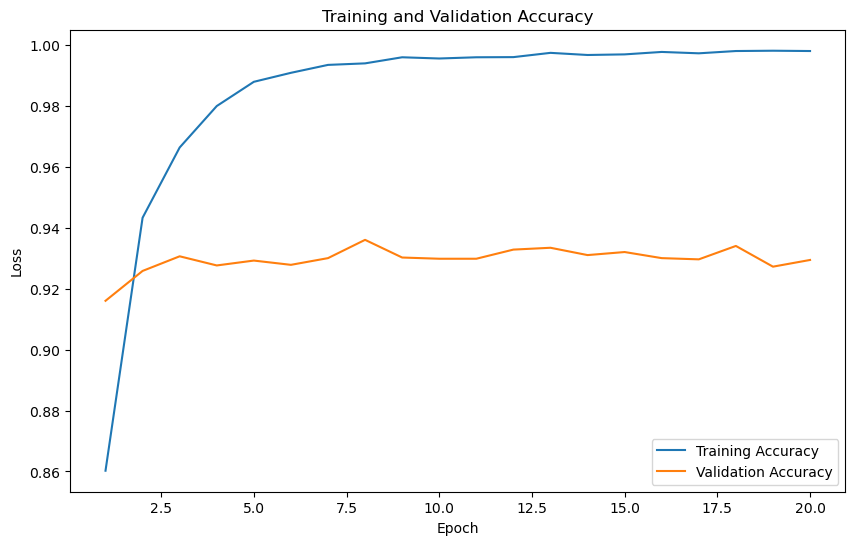

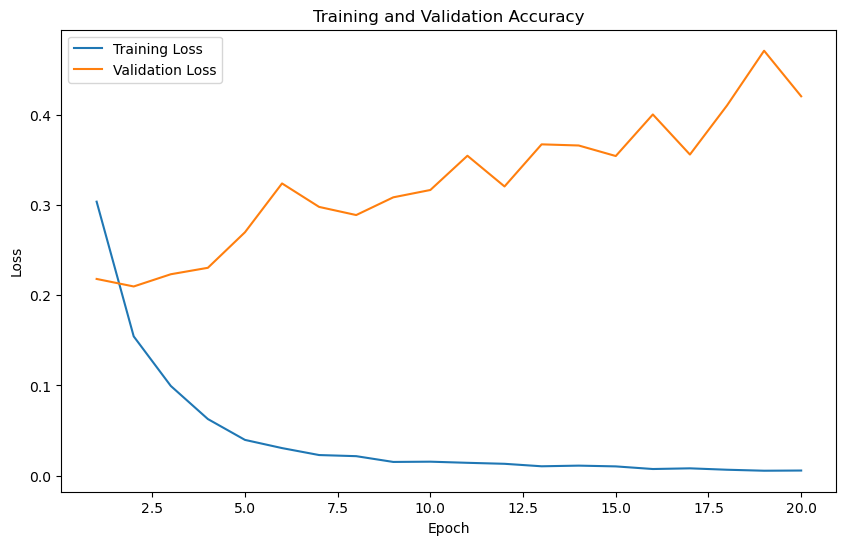

In [52]:
num_epochs = 20
batch_size = 32
train_loss_bert, train_acc_bert, val_loss_bert, val_acc_bert = train_bert(bert, num_epochs, batch_size, train_dataset_bert, val_dataset_bert, optimizer, loss_fn)
plot(train_acc_bert, val_acc_bert, "Training Accuracy", "Validation Accuracy", num_epochs)
plot(train_loss_bert, val_loss_bert, "Training Loss", "Validation Loss", num_epochs)

In [42]:
torch.cuda.empty_cache()

In [ ]:
# Logistic regression

In [53]:
# re-construct data set, list --> dict
def reconstruct(list_dataset):
    text = [comment['text'] for comment in list_dataset]
    label = [comment['label'] for comment in list_dataset]
    dataset = {}
    dataset['text'] = text
    dataset['label'] = label
    return dataset

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

# train set
tflr_trainset = comments['train']
tflr_testset = comments['test']


# randomly select 5000 datas
train_data = tflr_trainset.shuffle(seed=42).select([i for i in range(25000)])
test_data = tflr_testset.shuffle(seed=42).select([i for i in range(25000)])

# cv
train_dataset, val_dataset = split_data(train_data)

tflr_train_dataset = reconstruct(train_dataset)
tflr_val_dataset = reconstruct(val_dataset)
tflr_test_dataset = reconstruct(test_data)

# pre-processing and TF-IDF encode
tfidf_vectorizer = TfidfVectorizer(max_features=512, stop_words='english')
X_train = tfidf_vectorizer.fit_transform(tflr_train_dataset['text']).toarray()
X_val = tfidf_vectorizer.fit_transform(tflr_val_dataset['text']).toarray()
X_test = tfidf_vectorizer.fit_transform(tflr_test_dataset['text']).toarray()

Y_train = torch.tensor(tflr_train_dataset['label']).to(torch.float32)
Y_val = torch.tensor(tflr_val_dataset['label']).to(torch.float32)
Y_test = torch.tensor(tflr_test_dataset['label']).to(torch.float32)

X_train = torch.tensor(X_train).to(torch.float32)
X_val = torch.tensor(X_val).to(torch.float32)
X_test = torch.tensor(X_test).to(torch.float32)

train_set_lr = TensorDataset(X_train, Y_train)
val_set_lr = TensorDataset(X_val, Y_val)
test_set_lr = TensorDataset(X_test, Y_test)


In [73]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)  # 一个线性层

    def forward(self, x):
        out = self.linear(x)
        out = torch.sigmoid(out)
        return out

In [74]:
logistic_model = LogisticRegressionModel(512).to(torch.device('cuda'))
loss_fn = nn.BCELoss()
optimizer = optim.Adam(logistic_model.parameters(), lr=1e-3)

In [75]:
# train logistics regression
def train_lr(model, num_epochs, batch_size, train_dataset, val_dataset, optimizer, loss_fn):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    device = torch.device("cuda")

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        train_J = 0
        train_correct = 0
        train_total = 0
        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            model = model.to(device)
            outputs = model(inputs.to(device)).squeeze()
            loss = loss_fn(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            train_J += loss.to(torch.device('cpu')).item()

            predicted = torch.round(outputs)
            labels = labels.to(torch.device('cpu'))
            train_total += labels.size(0)
            train_correct += (predicted.to(torch.device('cpu')) == labels).sum().item()

        model.eval()
        with torch.no_grad():
            val_J = 0
            val_correct = 0
            val_total = 0
            for batch in val_loader:
                inputs, labels = batch
                outputs = model(inputs.to(device)).squeeze()
                loss = loss_fn(outputs, labels.to(device))
                val_J += loss.item()
                predicted = torch.round(outputs)
                labels = labels.to(torch.device('cpu'))
                val_total += labels.size(0)
                val_correct += (predicted.to(torch.device('cpu')) == labels).sum().item()



        train_accuracy = train_correct / train_total
        val_accuracy = val_correct / val_total
        train_J = train_J / len(train_loader)
        val_J = val_J / len(val_loader)
        train_acc.append(train_accuracy)
        train_loss.append(train_J)
        val_acc.append(val_accuracy)
        val_loss.append(val_J)

        print(f"Epoch {epoch + 1}, Train Loss: {train_J}, Validation Loss: {val_J}")
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy * 100:.2f}%")

    torch.cuda.empty_cache()

    return train_loss, train_acc, val_loss, val_acc

Epoch 1, Train Loss: 0.6521960438728333, Validation Loss: 0.6723994646862055
Epoch 1, Validation Accuracy: 62.64%
Epoch 2, Train Loss: 0.5866763537406922, Validation Loss: 0.658793320321733
Epoch 2, Validation Accuracy: 62.46%
Epoch 3, Train Loss: 0.5401467439174652, Validation Loss: 0.6492709688320282
Epoch 3, Validation Accuracy: 62.96%
Epoch 4, Train Loss: 0.5059138774871826, Validation Loss: 0.6439574171023764
Epoch 4, Validation Accuracy: 62.78%
Epoch 5, Train Loss: 0.4802081922054291, Validation Loss: 0.6391365493938421
Epoch 5, Validation Accuracy: 63.30%
Epoch 6, Train Loss: 0.4601034307479858, Validation Loss: 0.6362931846053737
Epoch 6, Validation Accuracy: 63.14%
Epoch 7, Train Loss: 0.444206595993042, Validation Loss: 0.6349956245179389
Epoch 7, Validation Accuracy: 63.24%
Epoch 8, Train Loss: 0.4313029692649841, Validation Loss: 0.6340290826217384
Epoch 8, Validation Accuracy: 63.62%
Epoch 9, Train Loss: 0.42090283958911895, Validation Loss: 0.6341970251623992
Epoch 9, Val

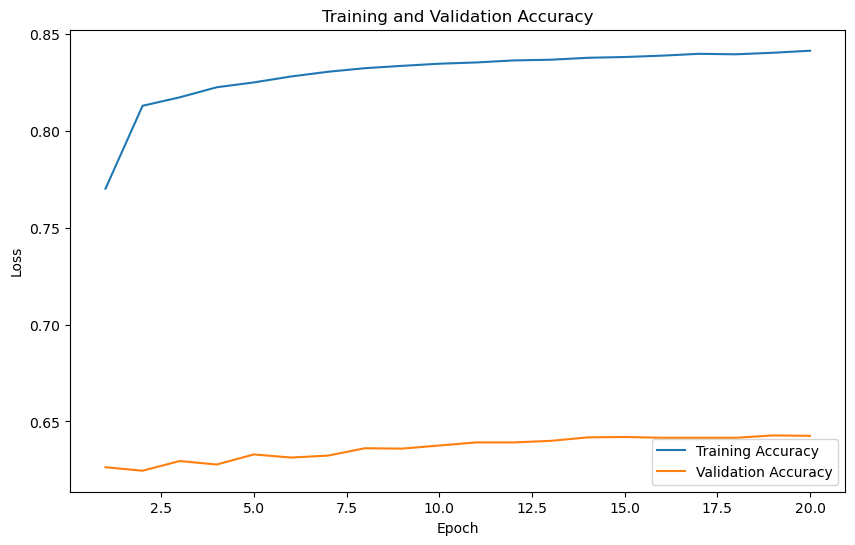

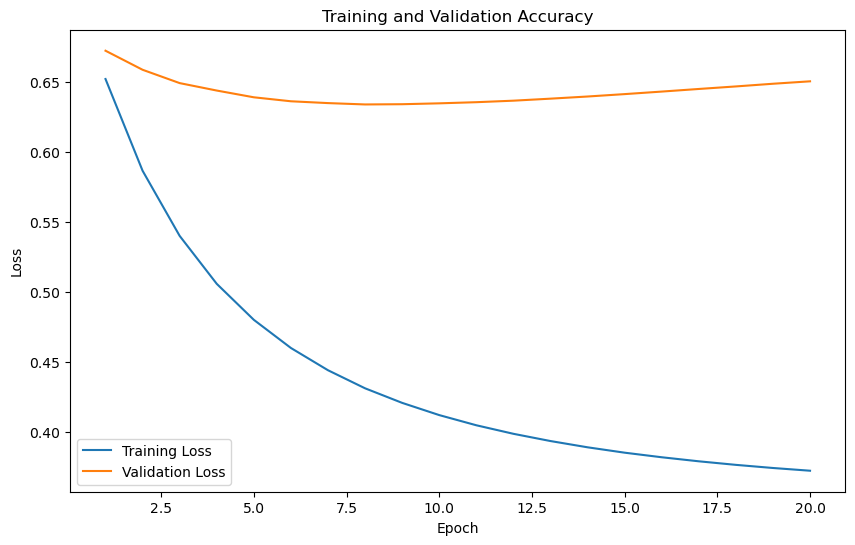

In [76]:
num_epochs = 20
batch_size = 32
train_loss_lr, train_acc_lr, val_loss_lr, val_acc_lr = train_lr(logistic_model, num_epochs, batch_size, train_set_lr, val_set_lr, optimizer, loss_fn)
plot(train_acc_lr, val_acc_lr, "Training Accuracy", "Validation Accuracy", num_epochs)
plot(train_loss_lr, val_loss_lr, "Training Loss", "Validation Loss", num_epochs)

In [59]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 8))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title("Confusion Matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, str(confusion_matrix[i][j]), horizontalalignment="center", color="black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

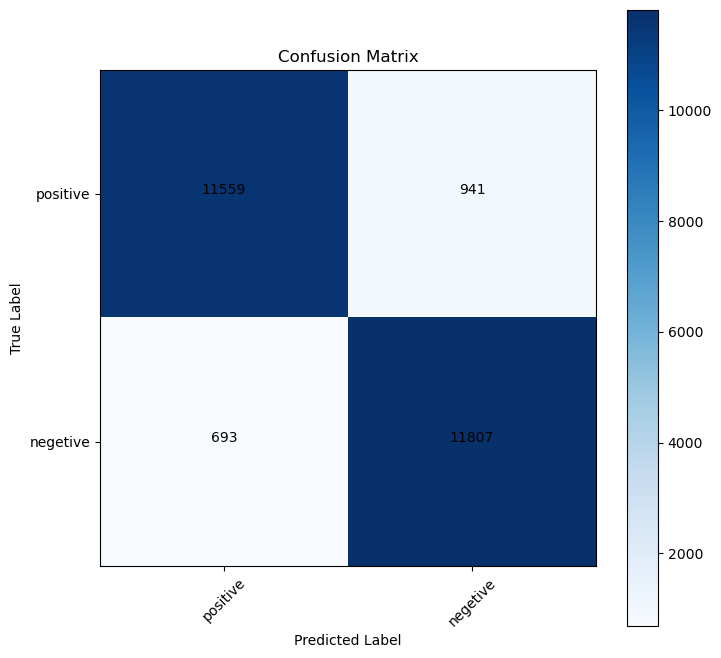

In [67]:
test_loader_bert = DataLoader(test_set_bert, batch_size=32, shuffle=True)
bert_predicted = []
bert_labels = []

bert.eval()
with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, labels = batch
        outputs = bert(input_ids.to(torch.device('cuda')), labels = labels.to(torch.device('cuda')))
        _, predicted = torch.max(outputs.logits, 1)
        labels = labels.to(torch.device('cpu'))
        bert_predicted = np.concatenate((bert_predicted, predicted.to(torch.device('cpu')).numpy()), axis=0)
        bert_labels = np.concatenate((bert_labels, labels.numpy()), axis=0)

confusion_matrix_bert = confusion_matrix(bert_labels, bert_predicted)
class_names = ['positive', 'negetive'] 
plot_confusion_matrix(confusion_matrix_bert, class_names)

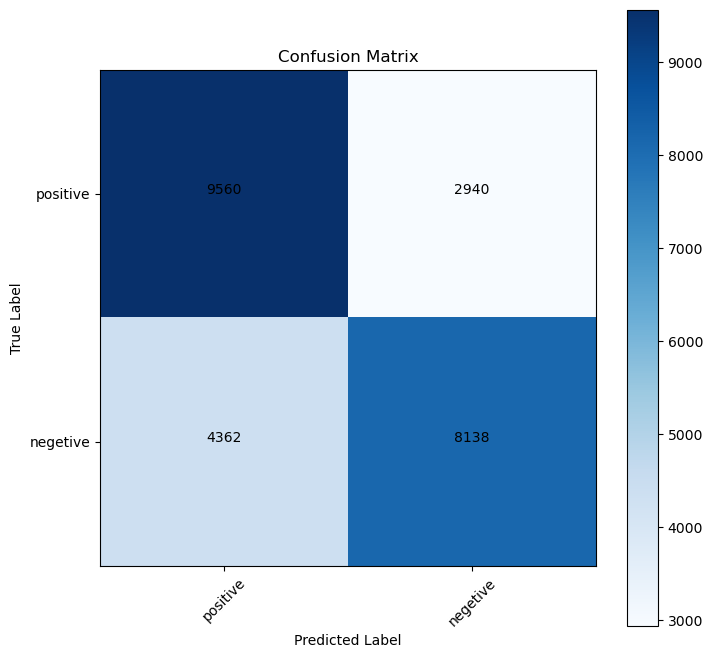

In [77]:
test_loader_lr = DataLoader(test_set_lr, batch_size=32, shuffle=True)
lr_predicted = []
lr_labels = []

logistic_model.eval()
with torch.no_grad():
    for batch in test_loader_lr:
        input_ids, labels = batch
        outputs = logistic_model(input_ids.to(torch.device('cuda'))).squeeze()
        predicted = torch.round(outputs)
        labels = labels.to(torch.device('cpu'))
        lr_predicted = np.concatenate((lr_predicted, predicted.to(torch.device('cpu')).numpy()), axis=0)
        lr_labels = np.concatenate((lr_labels, labels.to(torch.device('cpu')).numpy()), axis=0)

confusion_matrix_lr = confusion_matrix(lr_labels, lr_predicted)
class_names = ['positive', 'negetive'] 
plot_confusion_matrix(confusion_matrix_lr, class_names)

In [78]:
pip install shap

     -------------------------------------- 447.3/447.3 kB 9.5 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 55.2 MB/s eta 0:00:00
     -------------------------------------- 28.1/28.1 MB 131.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [79]:
import shap

In [80]:
import transformers
from transformers.pipelines.text_classification import TextClassificationPipeline

pipe = TextClassificationPipeline(model=bert.to('cpu'), tokenizer=tokenizer, top_k=None)
explainer = shap.Explainer(pipe)

In [81]:
shap_values = explainer(test_data['text'][:2])

PartitionExplainer explainer: 3it [02:53, 86.63s/it]               


In [82]:
shap.plots.text(shap_values)